The project is done on Google Colab

In [7]:
from google.colab import drive
drive.mount('/gdrive')
%cd/gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [8]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 3.4MB/s 
     |████████████████████████████████| 645kB 48.9MB/s 


### 1. Importing Librarys

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from fastai.text import * 
from fastai.callbacks import *
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
from pytorch_pretrained_bert import BertTokenizer
from shutil import copyfile
#import libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import nltk as nlp
import re

import warnings
warnings.filterwarnings('ignore')

In [14]:
#reading into pandas and renaming columns for easier api access
filepath = Path('../input/') #twitter-airline-sentiment
df = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Tweets.csv')
#df.rename(columns={'airline_sentiment':'label'},inplace=True)

#df = df[['label','text']]
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [15]:
data = df[["airline_sentiment","text","airline","retweet_count"]]
data.head()

,airline_sentiment,text,airline,retweet_count
0,neutral,@VirginAmerica What @dhepburn said.,Virgin America,0
1,positive,@VirginAmerica plus you've added commercials t...,Virgin America,0
2,neutral,@VirginAmerica I didn't today... Must mean I n...,Virgin America,0
3,negative,@VirginAmerica it's really aggressive to blast...,Virgin America,0
4,negative,@VirginAmerica and it's a really big bad thing...,Virgin America,0


### 2. EDA

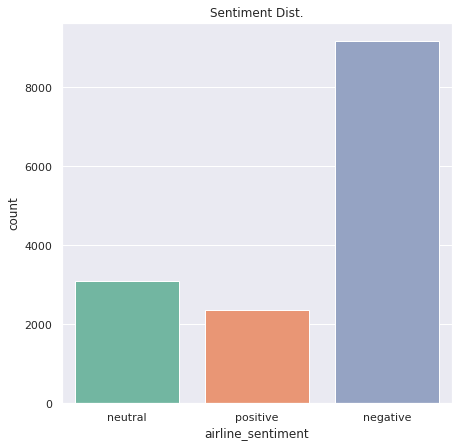

In [19]:
sns.set()
plt.figure(figsize=(7,7))
sns.countplot(x=data["airline_sentiment"],palette="Set2")
plt.title("Sentiment Dist.")
plt.show()

We see that the overall comments are negative. This may mean that you are generally unhappy with airline companies. However, this may also be due to the nature of twitter.

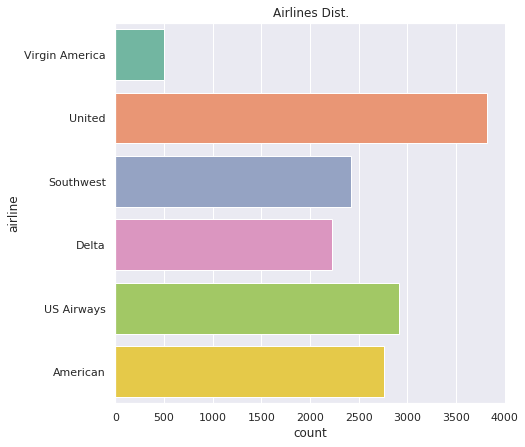

In [20]:
sns.set()
plt.figure(figsize=(7,7))
sns.countplot(y=data["airline"],palette="Set2")
plt.title("Airlines Dist.")
plt.show()

United airline is popular on Twitter. Of course, we don't know if this popularity is positive or negative. In addition, the fact that virgin america has very few twits gives the impression that the standard is neither good nor bad.

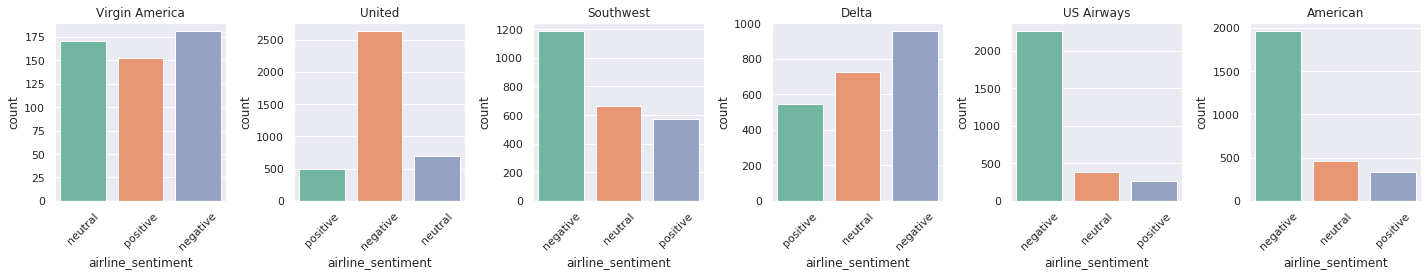

In [21]:
j=1
plt.subplots(figsize=(20,4),tight_layout=True)
for i in data["airline"].unique():
        x = data[data["airline"]==i]
        plt.subplot(1, 6, j)
        sns.countplot(x["airline_sentiment"],palette="Set2")
        plt.xticks(rotation=45)
        plt.title(i)
        j +=1
plt.show()

We are now able to comment on the emotions of the twits about companies. The United airline mentioned above has a very bad reputation in twitter. They also have negative reviews, which can be said that The United airline,US Airways and American offer poor service and have very bad reputation..

### 3. Data cleaning and tranformation

In the following, the twits are removed from unnecessary characters, converted to lowercase letters, separated into words and their roots are obtained.

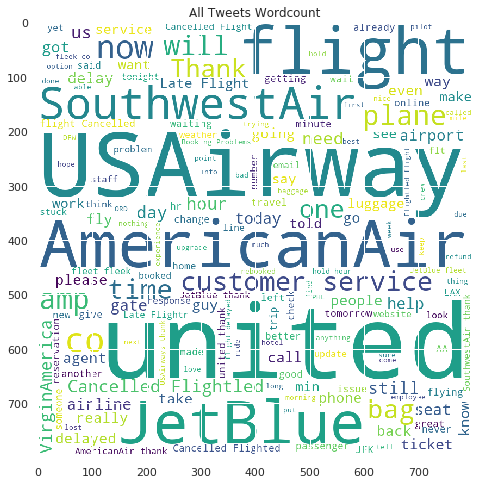

In [23]:
allcomments = " ".join(data.text)
wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = STOPWORDS, 
                    min_font_size = 12).generate(allcomments) 
      
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.title("All Tweets Wordcount")
plt.show()

In [25]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data["airline_sentiment"] = encoder.fit_transform(data["airline_sentiment"])
print(encoder.classes_)
data.head()

['negative' 'neutral' 'positive']


,airline_sentiment,text,airline,retweet_count
0,1,@VirginAmerica What @dhepburn said.,Virgin America,0
1,2,@VirginAmerica plus you've added commercials t...,Virgin America,0
2,1,@VirginAmerica I didn't today... Must mean I n...,Virgin America,0
3,0,@VirginAmerica it's really aggressive to blast...,Virgin America,0
4,0,@VirginAmerica and it's a really big bad thing...,Virgin America,0


In [26]:
# convert to categorical Categority by using one hot tecnique 
df_dummy = data.copy()
df_dummy.airline = pd.Categorical(df_dummy.airline)
x = df_dummy[['airline']]
del df_dummy['airline']
dummies = pd.get_dummies(x, prefix = 'airline')
data = pd.concat([df_dummy,dummies], axis=1)
data.head()

,airline_sentiment,text,retweet_count,airline_American,airline_Delta,airline_Southwest,airline_US Airways,airline_United,airline_Virgin America
0,1,@VirginAmerica What @dhepburn said.,0,0,0,0,0,0,1
1,2,@VirginAmerica plus you've added commercials t...,0,0,0,0,0,0,1
2,1,@VirginAmerica I didn't today... Must mean I n...,0,0,0,0,0,0,1
3,0,@VirginAmerica it's really aggressive to blast...,0,0,0,0,0,0,1
4,0,@VirginAmerica and it's a really big bad thing...,0,0,0,0,0,0,1


In [0]:
#normalize retweet count
_max = data.retweet_count.describe()[7]
data.retweet_count = [i/_max for i in data.retweet_count]

### 4. Model Training

In [28]:
#Encode Words
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = "english")
encoded_X = vectorizer.fit_transform(data.text).toarray()
print(encoded_X.shape)
print("Features First 100:",vectorizer.get_feature_names()[:100])

(14640, 14770)
Features First 100: ['00', '000', '000114', '000419', '000ft', '000lbs', '0011', '0016', '00a', '00am', '00p', '00pm', '01', '0162389030167', '0162424965446', '0162431184663', '0167560070877', '0185', '01ldxn3qqq', '01pm', '02', '0200', '03', '0316', '0372389047497', '04', '0400', '04sdytt7zd', '05', '0510', '0530', '05am', '05pm', '06', '0600', '0638', '0671', '07', '0736', '0769', '07p', '07xhcacjax', '08', '0985', '0_0', '0bjnz4eix5', '0cevy3p42b', '0ewj7oklji', '0hmmqczkcf', '0hxlnvzknp', '0jjt4x3yxg', '0jutcdrljl', '0kn7pjelzl', '0liwecasoe', '0pdntgbxc6', '0prgysvurm', '0wbjawx7xd', '0xjared', '10', '100', '1000', '1000cost', '1001', '1002', '1007', '1008', '101', '1016', '1019', '1020', '1024', '1025', '1027', '1028', '103', '1030pm', '1032', '1038', '104', '1041', '1046', '105', '1050', '1051', '1058', '106', '1065', '1071', '1074', '1079871763', '108', '1080', '1081', '1086', '108639', '1089', '1098', '1099', '10a', '10am']


In [29]:
data2 = data.copy()
del data2["text"]
data2 = pd.concat([pd.DataFrame(encoded_X),data2], axis=1)
data2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,14738,14739,14740,14741,14742,14743,14744,14745,14746,14747,14748,14749,14750,14751,14752,14753,14754,14755,14756,14757,14758,14759,14760,14761,14762,14763,14764,14765,14766,14767,14768,14769,airline_sentiment,retweet_count,airline_American,airline_Delta,airline_Southwest,airline_US Airways,airline_United,airline_Virgin America
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0,0,0,0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0,0,0,0,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0,0,0,0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0,0,1


In [0]:
X = data2.drop(["airline_sentiment"],axis=1)
y = data2.airline_sentiment

#### Split train and test data

In [31]:
#Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=22)
print("Train :",X_train.shape)
print("Test  :",X_test.shape)

Train : (10980, 14777)
Test  : (3660, 14777)


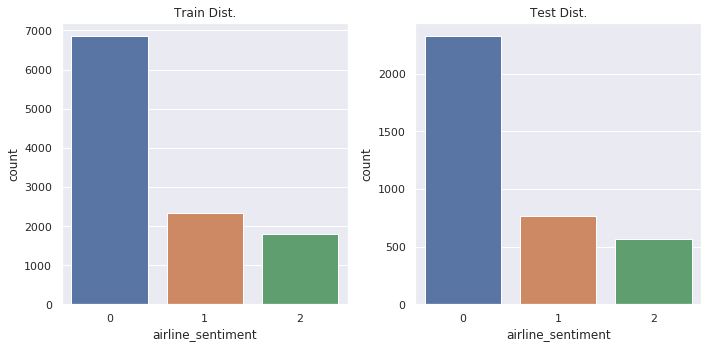

In [32]:
sns.set()
plt.subplots(figsize=(10,5),tight_layout=True)
plt.subplot(1,2,1)
sns.countplot(y_train)
plt.title("Train Dist.")
plt.subplot(1,2,2)
sns.countplot(y_test)
plt.title("Test Dist.")
plt.show()

In [0]:
#Classification
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

### 5. Model evaluation

In [34]:
#Result
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

rf_acc = accuracy_score(y_test, pred)
rf_f1 = f1_score(y_test, pred, average="micro")

print("Random Forest")
print("Accuracy : %",round(rf_acc*100,2))
print("F1 Score : %",round(rf_f1*100,2))

Random Forest
Accuracy : % 75.82
F1 Score : % 75.82


### The END